## **Capstone Sprint 1**

### **Submitted by:** Jiro Amato

### **Date:** May, 30, 2024

Introduction:

In this notebook, we wll be going through a first pass of the training dataset for the sentiment analysis model. This dataset contains 4,840 financial articles that have been classified as positive, neutral or negative by 16 financial professionals. It is crucial to complete this step as it sets the foundation for the rest of the model. We will be looking through text-preprocessing and some EDA using techniques such as Bag of Words and TF-IDF to vecotrize the text data.

**Other datasets of the project (will investigate further):**

The second dataset of the project contains daily news gather from 2009-2020 which has the following:

### Data Dictionary (2nd Dataset)

**Column Name:**   
Contains **843,062** unique articles.

- `headline:` The headline of the news article
- `url:` Link to the article
- `publisher:` Name of the publisher
- `date:` Date the article was released
- `stock:` The stock that the article refers to

Lastly, the third dataset contains the daily historical price of the S&P 500 index from 2000-2024 which has the following:

### Data Dictionary (3rd Dataset)

**Column Name:**
Contains **6,038** observations.  

- `Date:` Date of when the price was recorded
- `Open:` Price level during the market opening
- `High:` Highest that price went to during trading hours
- `Low:` Lowest that price went to during trading hours
- `Adj Close:` The closing price (adjusted to include any corporate decision made before the next trading day)
- `Volume:` The total amount that the index was traded expressed in $

## Table of Contents

[Preface](#Preface:-Verifying-the-cleanliness-of-our-data) <br>
- [Loading Datasets](#Loading-Datasets)
- [Data Dictionary](#Data-Dictionary)
- [Nulls](#Checking-for-nulls)
- [Duplicates](#Checking-for-duplicates)

[1. EDA](#1.-Exploratory-Data-Analysis) <br>
- [1.1. Sentiment Breakdown](#1.1.-Sentiment-Breakdown/Imbalance) <br>
- [1.2. Counts of words and characters](#1.2.-Counts-of-words-and-characters)

[2. Vectorization](#2.-Vectorization) <br>
- [2.1. Data Standardization](#2.1.-Data-Standardization) <br>
- [2.2. Tokenization and Lemmatization](#2.2.-Tokenization-and-Lemmatization)
- [2.3. Stop-word and empty string removal](#2.3.-Stop-word-and-empty-string-removal)
- [2.4. Custom Tokenizer](#2.4.-Custom-Tokenizer)
- [2.5. Bag of Words](#2.5.-Bag-of-Words)
- [2.6. TF-IDF](#2.6.-TF-IDF)

[3. Next Steps](#3.-Next-Steps) <br>

In [22]:
# Importing necessary libraries

# Libraries for data manipulation
import numpy as np
import pandas as pd
import os # For path name manipulation

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Train/Test splitting
from sklearn.model_selection import train_test_split

# NLP specific libraries
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amato\AppData\Roaming\nltk_data...


## Preface: Verifying the cleanliness of our data

### Loading Datasets

Sourced code to open multiple files in a for-loop [here](https://saturncloud.io/blog/how-to-import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe/).

In [23]:
# Loading the dataset for training the sentiment analysis model

# Instantiating an empty dataframe
phrase_bank_df = pd.DataFrame()

# Creating a list of the file names for a for-loop
files = ['Sentences_AllAgree.txt', 'Sentences_75Agree.txt', 'Sentences_66Agree.txt', 'Sentences_50Agree.txt']
path = 'C:/Users/amato/Desktop/Brainstation/Capstone/data/'

# For-loop to load in all the files and combine them into one
for file in files:
    df = pd.read_csv(os.path.join(path, file), encoding='ISO-8859-1', delimiter='@', names=['Headline', 'Sentiment'])  # The files are in "@" separated format
    phrase_bank_df = pd.concat([phrase_bank_df, df], axis=0, ignore_index=True)

phrase_bank_df


,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
14775,LONDON MarketWatch -- Share prices ended lower...,negative
14776,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
14777,Operating profit fell to EUR 35.4 mn from EUR ...,negative
14778,Net sales of the Paper segment decreased to EU...,negative


### Data Dictionary

**Column Name:**   

- `Headline:` The headline of the news article
- `Sentiment:` Classifications by positive, neutral or negative. These classifications were agreed upon by 16 professionals in the Finance domain.

### Checking for nulls

In [24]:
# Checking for nulls

phrase_bank_df.isna().sum()

Headline     0
Sentiment    0
dtype: int64

We do not have any null values.

### Checking for duplicates

In [25]:
# Checking for duplicates

phrase_bank_df.duplicated(keep='first').sum()

9940

We have 9,940 duplicates in our dataframe. Let's check what they are .

In [26]:
phrase_bank_df[phrase_bank_df.duplicated(keep='first') == True].head()

,Headline,Sentiment
519,The issuer is solely responsible for the conte...,neutral
626,The report profiles 614 companies including ma...,neutral
929,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
1027,SSH Communications Security Corporation is hea...,neutral
1409,The company serves customers in various indust...,neutral


In [27]:
# Dropping duplicates

phrase_bank_df = phrase_bank_df.drop_duplicates(keep='first', ignore_index=True)

In [28]:
# Sanity check

phrase_bank_df.duplicated().sum()

0

In [29]:
# Checking the cleaned dataframe

phrase_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4840 entries, 0 to 4839
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headline   4840 non-null   object
 1   Sentiment  4840 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


The dataframe now has 4840 rows with no nulls and duplicates. We can now proceed to start with an EDA and data-preprocessing.

## 1. Exploratory Data Analysis

### 1.1. Sentiment Breakdown/Imbalance

The first thing that I will be exploring is the breakdown of sentiment in the dataset. After, I will be simplifying the problem statement by combining neutral with positive to just have a binary sentiment output

In [30]:
# Breakdown of positive, neutral and negative sentiments in percentages

positive = phrase_bank_df['Sentiment'].value_counts()['positive'] # We know from our last code that we have 4840 observations
negative = phrase_bank_df['Sentiment'].value_counts()['negative']
neutral = phrase_bank_df['Sentiment'].value_counts()['neutral']

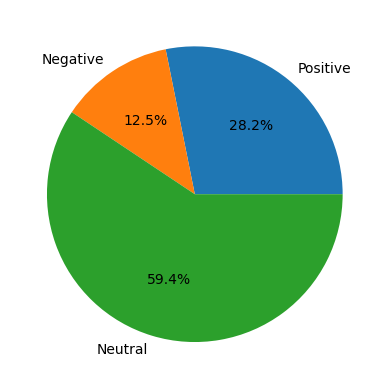

In [31]:
# Pie chart to show the breakdown of sentiment in the dataset
plt.figure()
plt.pie([positive, negative, neutral], labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%')
plt.show()

We can see that the neutral sentiment make up almost 60% of our data with positive at 28.2% and negative at 12.5%. The financial phrase bank is not balanced when it comes to outcomes. If we consolidate `Neutral` to `Positive` we will have data that is tremendously unbalanced towards positive sentiment. By looking at this, it seems more reasonable to consolidate `Neutral` into `Negative`instead. Although the data will still be unbalanced, it will not be as bad as if we consolidated `Neutral` and `Positive` together.

In [32]:
# Mapping sentiments into binary (consolidating neutral into negative)

phrase_bank_df['Sentiment'] = np.where(phrase_bank_df['Sentiment'] == 'positive', 1, 0)

# Sanity check
phrase_bank_df['Sentiment'].value_counts()


C:\Users\amato\AppData\Local\Temp\ipykernel_65328\1271611503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_bank_df['Sentiment'] = np.where(phrase_bank_df['Sentiment'] == 'positive', 1, 0)


Sentiment
0    3477
1    1363
Name: count, dtype: int64

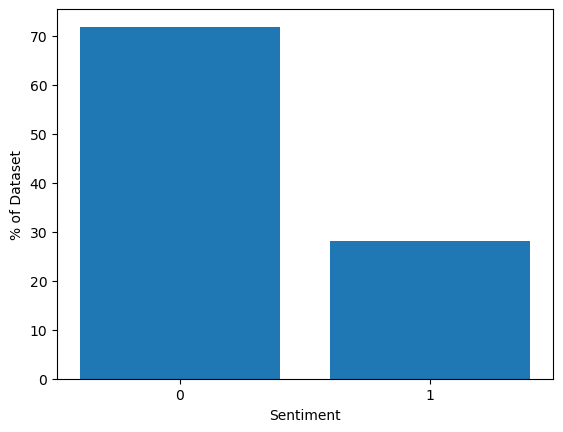

Class imbalance: [0.72 0.28]


In [33]:
# Class imbalance

values, counts = np.unique(phrase_bank_df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Sentiment')
plt.ylabel('% of Dataset')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

Quite a big class imbalance here. Since this is a first pass EDA, we will see where this takes us for now. Some changes that I am already thinking about for future iterations are implementing models that allow for multi-class classification like KNN and DT. Logistic regression is also capable of this but it is costly in computation (we can accept this as our dataset is relatively low).

### 1.2. Counts of words and characters

Before we start vectorizing our data, it is good to explore the nature of our headlines when it comes to the count of characters and words. We will do the following below:

In [34]:
# Checking the length of characters in each headline
length = len(phrase_bank_df['Headline'][0])


In [35]:
print(phrase_bank_df['Headline'][0])
print(length)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
127


In [36]:
# Creating a new column that calculates the number of characters in each headline
phrase_bank_df['char_count'] = phrase_bank_df['Headline'].apply(lambda x: len(x))

# Sanity check
phrase_bank_df.head()

C:\Users\amato\AppData\Local\Temp\ipykernel_65328\192333379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_bank_df['char_count'] = phrase_bank_df['Headline'].apply(lambda x: len(x))


,Headline,Sentiment,char_count
0,"According to Gran , the company has no plans t...",0,127
1,"For the last quarter of 2010 , Componenta 's n...",1,193
2,"In the third quarter of 2010 , net sales incre...",1,125
3,Operating profit rose to EUR 13.1 mn from EUR ...,1,122
4,"Operating profit totalled EUR 21.1 mn , up fro...",1,103


In [37]:
# Counting the words in a headline using split() and len()
word_count = len(phrase_bank_df['Headline'][0].split())
print(word_count)

25


In [38]:
# Applying to the entire row
phrase_bank_df['word_count'] = phrase_bank_df['Headline'].str.split().apply(len)

# Sanity check
phrase_bank_df.head()

C:\Users\amato\AppData\Local\Temp\ipykernel_65328\1647580670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phrase_bank_df['word_count'] = phrase_bank_df['Headline'].str.split().apply(len)


,Headline,Sentiment,char_count,word_count
0,"According to Gran , the company has no plans t...",0,127,25
1,"For the last quarter of 2010 , Componenta 's n...",1,193,39
2,"In the third quarter of 2010 , net sales incre...",1,125,29
3,Operating profit rose to EUR 13.1 mn from EUR ...,1,122,24
4,"Operating profit totalled EUR 21.1 mn , up fro...",1,103,22


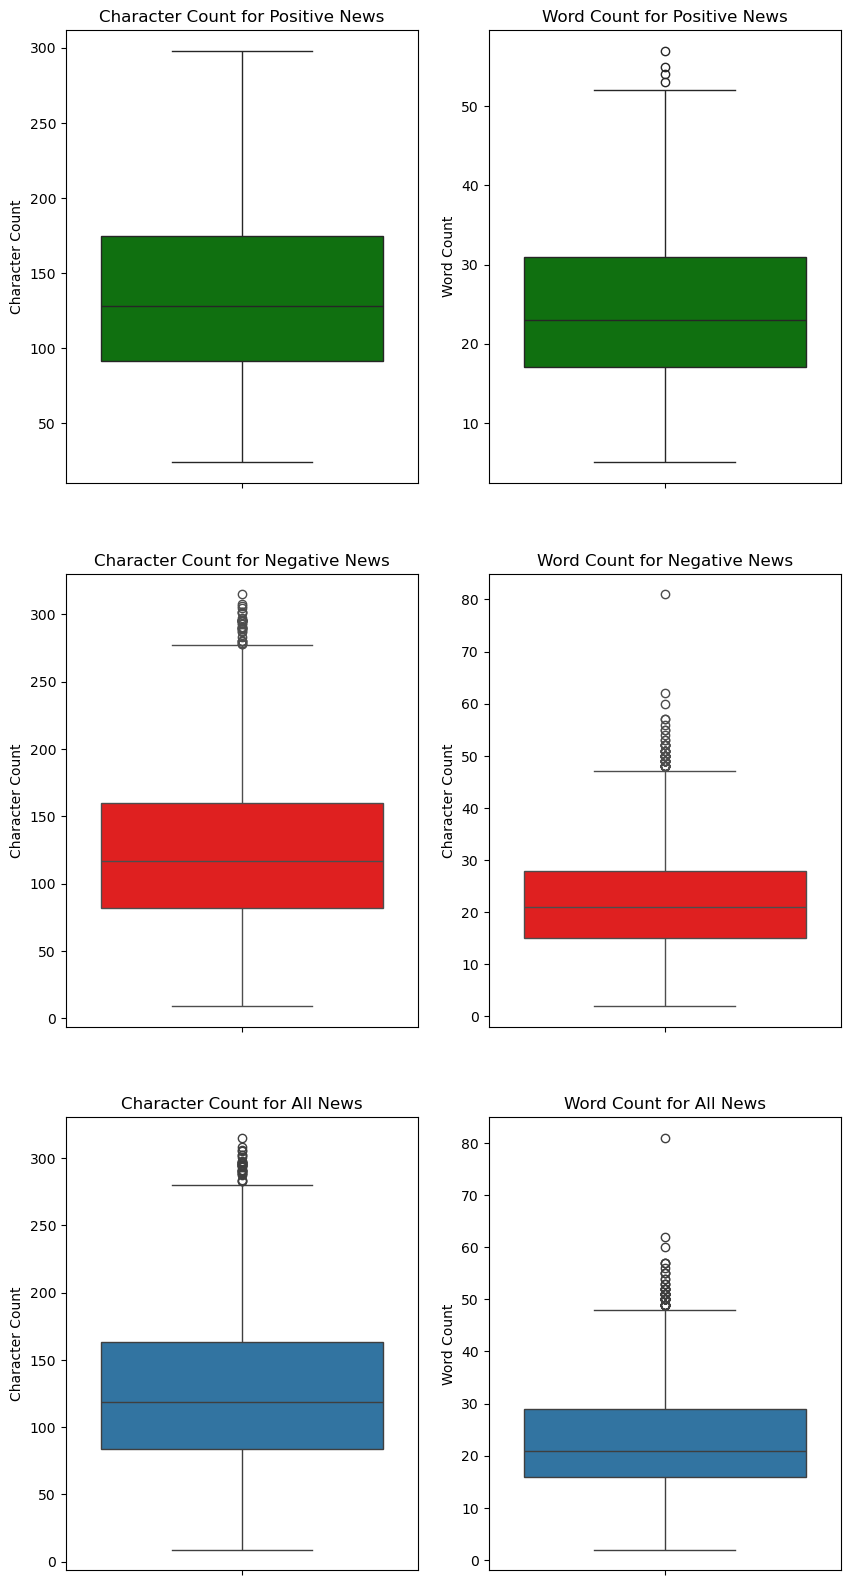

In [39]:
# Visualizing the character and word counts in box plots

plt.subplots(3, 2, figsize=(10, 20))

plt.subplot(3, 2, 1)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 1, 'char_count'], color='green')
plt.ylabel('Character Count')
plt.title('Character Count for Positive News')

plt.subplot(3, 2, 2)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 1, 'word_count'], color='green')
plt.ylabel('Word Count')
plt.title('Word Count for Positive News')

plt.subplot(3, 2, 3)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 0, 'char_count'], color='red')
plt.ylabel('Character Count')
plt.title('Character Count for Negative News')

plt.subplot(3, 2, 4)
sns.boxplot(y=phrase_bank_df.loc[phrase_bank_df['Sentiment'] == 0, 'word_count'], color='red')
plt.ylabel('Character Count')
plt.title('Word Count for Negative News')

plt.subplot(3, 2, 5)
sns.boxplot(y=phrase_bank_df['char_count'])
plt.ylabel('Character Count')
plt.title('Character Count for All News')

plt.subplot(3, 2, 6)
sns.boxplot(y=phrase_bank_df['word_count'])
plt.ylabel('Word Count')
plt.title('Word Count for All News')

plt.show()

## 2. Vectorization

The next part of our data preprocessing is to vectorize our `Headline` column in order to make our data approriate inputs to any model.

### 2.1. Data Standardization

In this step I am going to transform the headlines all in lowercase and take out punctuations.

In [40]:
sentence = phrase_bank_df['Headline'][0]

for punctuation in string.punctuation:
    sentence = sentence.replace(punctuation,'')

sentence_new = sentence.lower()
sentence_new

'according to gran  the company has no plans to move all production to russia  although that is where the company is growing '

### 2.2. Tokenization and Lemmatization

After taking out the punctuations, I am going to split the headline into a list of words which I then lemmatize.

Lemmatization is the process of reducing a word to its root form called 'lemma'. This is the dictionary form of a root (ex: laziness to lazy). This allows us to have more accurate and meaningful root words in comparison to stemming where it can lead to unusual rootwords as it is 'rules-based' rather than vocabulary-based (ex: laziness to lazi). For this reason, I will attempt to lemmatize the dataset. The only draw back of lemmatization is the computational cost but since we are dealing with a rather small dataset, we can afford to lose some efficiency for accuracy.

In [41]:
# Splitting the headline into a list of words
listofwords = sentence_new.split(' ')
listofwords

['according',
 'to',
 'gran',
 '',
 'the',
 'company',
 'has',
 'no',
 'plans',
 'to',
 'move',
 'all',
 'production',
 'to',
 'russia',
 '',
 'although',
 'that',
 'is',
 'where',
 'the',
 'company',
 'is',
 'growing',
 '']

In [45]:
# Lemmatization

wnl = WordNetLemmatizer()

lemmatized_sentence = [wnl.lemmatize(i) for i in listofwords]
lemmatized_sentence

['according',
 'to',
 'gran',
 '',
 'the',
 'company',
 'ha',
 'no',
 'plan',
 'to',
 'move',
 'all',
 'production',
 'to',
 'russia',
 '',
 'although',
 'that',
 'is',
 'where',
 'the',
 'company',
 'is',
 'growing',
 '']

### 2.3. Stop-word and empty string removal

The next step is to remove any stop-words (words without significant meaning such as 'the' and 'like') and any leftover whitespaces.

In [49]:
# Removing stop-words and empty strings

stop_words = stopwords.words('english')

words_final = [word for word in lemmatized_sentence if word not in stop_words and (word != '')]
words_final

['according',
 'gran',
 'company',
 'ha',
 'plan',
 'move',
 'production',
 'russia',
 'although',
 'company',
 'growing']

As expected, we now have processed the headline appropriately and is ready to be vectorized.

### 2.4. Custom-Tokenizer

Putting all of the steps above into one function.

In [50]:
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def my_tokenizer(sentence):
    # transform string into lower case and take out punctuations
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '').lower()

    # tokenization
    listofwords = sentence.split(' ')
    lemmatized_words = []

    # removal of stop-words
    for word in listofwords:
        if word not in stop_words and (word != ''):
            # lemmatizing
            lemma = wnl.lemmatize(word)
            lemmatized_words.append(lemma)

    return lemmatized_words

### 2.5. Bag of Words

Now that I have created my own tokenizer, I am going to tokenize the dataset. Here we will be using Bag of words with a min_df=5.


In [75]:
# Split the data into Features and Target

X = phrase_bank_df['Headline']
y = phrase_bank_df['Sentiment']

# Sanity Check
print(X, '\n')
print(y)

0       According to Gran , the company has no plans t...
1       For the last quarter of 2010 , Componenta 's n...
2       In the third quarter of 2010 , net sales incre...
3       Operating profit rose to EUR 13.1 mn from EUR ...
4       Operating profit totalled EUR 21.1 mn , up fro...
                              ...                        
4835    Bosse added that Trygvesta does not have the f...
4836    Finnish-Swedish Stora Enso does not understand...
4837    The 2015 target for net sales has been set at ...
4838    have notified that as a result of the Company ...
4839    Net sales of the Paper segment decreased to EU...
Name: Headline, Length: 4840, dtype: object 

0       0
1       1
2       1
3       1
4       1
       ..
4835    0
4836    0
4837    1
4838    0
4839    0
Name: Sentiment, Length: 4840, dtype: int32


In [58]:
# Split the data into Train/Test Split. I will use a test split of 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [59]:
# Vectorize

bagofwords = CountVectorizer(min_df=5, 
                             tokenizer=my_tokenizer)
bagofwords.fit(X_train)

X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

X_train_transformed.shape

c:\Users\amato\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3872, 1757)

From our sparse matrix we can visualize the most frequently occuring words in our corpus.

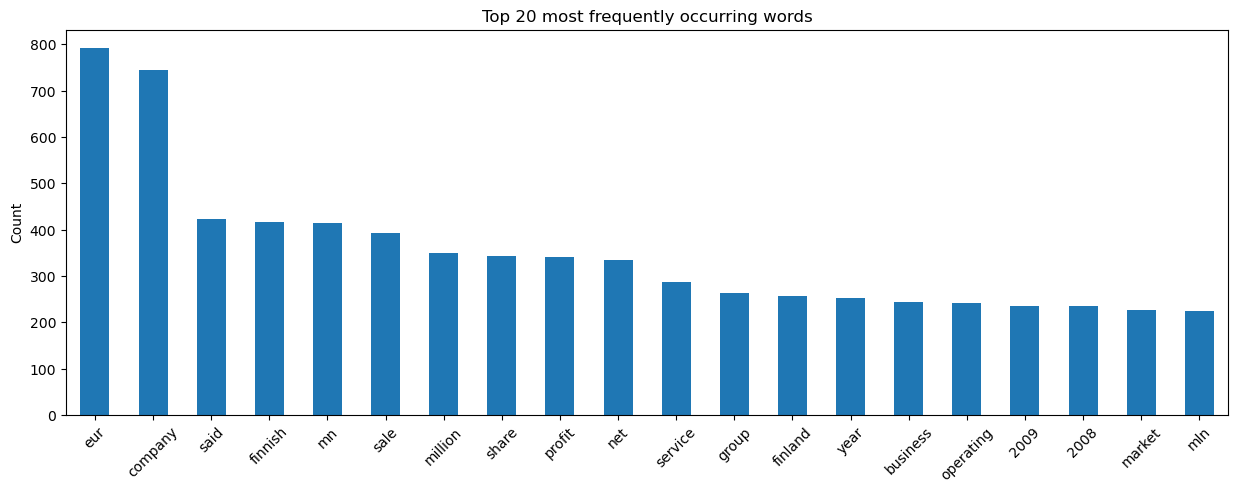

In [65]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

It looks like `eur` and `company` are the most frequent words in our corpus.

### 2.6. TF-IDF

This way of vectorizing is different than in bag of words as it gives emphasis on the frequency of the word within each document and also how rare the word is in the entire corpus.

In [71]:
# using our custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5,
                        tokenizer=my_tokenizer)
tfidf.fit(X_train)

X_train_transformed = tfidf.transform(X_train)
X_test_transformed = tfidf.transform(X_test)

c:\Users\amato\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


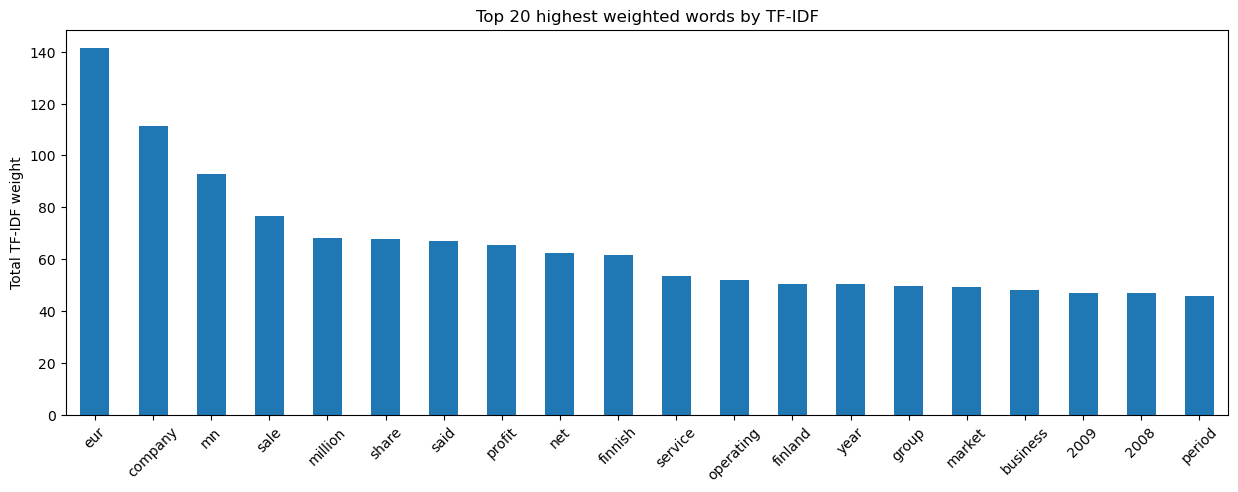

In [73]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

It looks like we are getting the similar results as Bag of words. There are some words like million which are emphasized more using TF-IDF and words that weigh less like 'finnish' which are emphasized more in Bag of Words. This graph however looks at the weights associated with each lemma instead of frequency so the differences are tp be expected

## 3. Next Steps

Now that our data is in numerical form through vectorization, the next steps are to run the appropriate models of classification. So far we have gone over the following: Logistic Regression, KNN and Decision Tree. Compare the performance over all the models. 

Another topic to visit is to run other vectorization models for text data such as `word2vec` in order to achieve more accurate results. Some models such as VADER (Valence Aware Dictionary and sEntiment Reasoner) don't need vectorization in its data. Comparing the different NLP models is crucial as a next-step.

After a model is chosen for sentiment analysis, I will then apply that model to classify the test data for this project which is a collection financial news gathered from 2009 to 2020.

###